In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from timkf.pipeline import PulsarDataLoader
from timkf.misc import plot_medians_hist
import scienceplots  # noqa

plt.style.use(["science"])

UTMOST_DATA_PATH = "../data/TimingDataRelease1/pulsars"
PSR_NAME = "J1359-6038"
# PSR_NAME = "J1709-1640"
# PSR_NAME = "J0437-4715"
PARFILE = f"{UTMOST_DATA_PATH}/{PSR_NAME}/{PSR_NAME}.par"
TIMFILE = f"{UTMOST_DATA_PATH}/{PSR_NAME}/{PSR_NAME}.tim"
NUME_IMPL = "numpy"
ORIG_WD = os.getcwd()

Numpy version is compatible with longdouble.
np.finfo(np.longdouble).eps 2.220446049250313e-16
np.longdouble is equivalent to np.float64.
Downcasting to np.float64.
Using NP_LONGDOUBLE_TYPE: <class 'numpy.float64'>


In [2]:
def find_sorted_subdirs(
    outdir,
    irrelevant_subdirs=None,
    restrict_to=None,
) -> list[str]:
    if irrelevant_subdirs is None:
        irrelevant_subdirs = ["outdir_err", "outdir_log", "hrchy"]

    def sort_func(x: str):
        return x.lower()

    subdirs = [d for d in os.listdir(outdir) if os.path.isdir(os.path.join(outdir, d))]

    for irsd in irrelevant_subdirs:
        if irsd in subdirs:
            subdirs.remove(irsd)

    if np.isscalar(restrict_to):
        restrict_to = [sort_func(sd) for sd in subdirs][:restrict_to]
    if restrict_to is not None:
        subdirs = [sd for sd in subdirs if sort_func(sd) in restrict_to]

    subdirs.sort(key=sort_func)
    return subdirs


psr_names_sorted = find_sorted_subdirs(UTMOST_DATA_PATH)

In [3]:
print(", ".join(psr_names_sorted))

J0030+0451, J0134-2937, J0151-0635, J0152-1637, J0206-4028, J0255-5304, J0348+0432, J0401-7608, J0418-4154, J0437-4715, J0450-1248, J0452-1759, J0525+1115, J0529-6652, J0533+0402, J0536-7543, J0601-0527, J0624-0424, J0627+0706, J0630-2834, J0646+0905, J0659+1414, J0711-6830, J0729-1836, J0737-3039A, J0738-4042, J0742-2822, J0758-1528, J0809-4753, J0820-1350, J0820-4114, J0835-4510, J0837+0610, J0837-4135, J0840-5332, J0842-4851, J0846-3533, J0855-3331, J0856-6137, J0904-4246, J0904-7459, J0907-5157, J0908-1739, J0908-4913, J0909-7212, J0922+0638, J0924-5302, J0924-5814, J0934-5249, J0942-5552, J0942-5657, J0944-1354, J0953+0755, J0955-5304, J0959-4809, J1001-5507, J1003-4747, J1012-5857, J1013-5934, J1016-5345, J1017-5621, J1017-7156, J1022+1001, J1032-5911, J1034-3224, J1036-4926, J1041-1942, J1042-5521, J1043-6116, J1045-4509, J1046-5813, J1047-6709, J1048-5832, J1056-6258, J1057-5226, J1057-7914, J1059-5742, J1105-6107, J1110-5637, J1112-6613, J1112-6926, J1114-6100, J1116-4122, J11

In [ ]:
from pathlib import Path
from psrdb.graphql_client import GraphQLClient
from psrdb.tables.pulsar_fold_result import PulsarFoldResult

print(f"Current working directory: {ORIG_WD}")
MEERTIME_DIR = f"{ORIG_WD}/../data/meertime-utmostPSR"
MEERTIME_DIR = Path(MEERTIME_DIR).resolve()
MEERTIME_DIR.mkdir(exist_ok=True)
print(f"Resolved MEERTIME_DIR to {MEERTIME_DIR}")
os.environ["PSRDB_TOKEN"] = "<>"  # replace with your token
url = os.environ.get("PSRDB_URL", "https://pulsars.org.au/api/")

client = GraphQLClient(url, os.environ["PSRDB_TOKEN"])
pfr = PulsarFoldResult(client)

for psr in psr_names_sorted:
    if os.path.exists(MEERTIME_DIR / f"pulsar_fold_result_{psr}.csv"):
        print(f"File for {psr} already exists, skipping download", end="\r")
        continue
    try:
        fname = pfr.download(psr)  # returns 'pulsar_fold_result_<PSR>.csv'
        print(f"Downloaded fold result to {fname}")
        Path(fname).replace(MEERTIME_DIR / fname)
    except Exception as e:
        print(f"Error downloading {psr}: {e}")


Current working directory: /Users/Eric.Dong/Downloads/project-psrtim_population/notebooks
Resolved MEERTIME_DIR to /Users/Eric.Dong/Downloads/project-psrtim_population/data/meertime-utmostPSR


$\Delta_{\rm DM} = K f^{-2} \text{DM}(t)$, where $K \approx 4.149\,\text{ms}\,\text{GHz}^{2}\,\text{pc}^{-1}\,\text{cm}^{3}$

In [5]:
from astropy.time import Time
from astropy.stats import sigma_clip

K_DM = 4.149  # ms GHz^2 pc^-1 cm^3
MHz_to_GHz = 1e-3
MICROSEC_TO_MSEC = 1e-3
SEC_TO_MSEC = 1e3
YEAR_TO_DAY = 365


def delDM_bound_from_timing_noise(tempo_psr):
    # toaerrs = tempo_psr.toaerrs * MICROSEC_TO_MSEC  # convert to ms
    # print(f"min, max TOA errors (ms): {toaerrs.min()}, {toaerrs.max()}")
    residuals = tempo_psr.residuals() * SEC_TO_MSEC  # in ms
    # print(
    #     f"min, max Residuals (ms): {np.min(np.abs(residuals))}, {np.max(np.abs(residuals))}"
    # )
    freq_bands = tempo_psr.freqs * MHz_to_GHz  # convert to GHz
    # print(f"Median Frequencies (GHz): {np.median(freq_bands)}")
    DM_variations = residuals / (K_DM * freq_bands**-2)
    # print(f"max required DM variations (pc cm^-3): {np.abs(DM_variations).max()}")
    return DM_variations


def utc_to_mjd(utc: pl.Series):
    # parse "UTC Start" to datetime
    utc_dt = utc.str.to_datetime(time_unit="ns")
    # convert to MJD using astropy
    mjds = Time(utc_dt.to_numpy().astype("datetime64[ns]"), scale="utc").mjd
    return mjds


def delDM_estimate_from_DM_measurements(
    df: pl.DataFrame,
    # Tobs_mjd: tuple[float, float] = (None, None),
    clip_sigma: float = 3,
    return_fit: bool = False,
    fit_order: int = 1,
):
    if df.is_empty():
        return np.nan
    if df["DM (pc cm^-3)"].is_null().all():
        return np.nan

    valid_dm_mask = df["DM (pc cm^-3)"].is_not_nan()
    df = df.filter(valid_dm_mask)

    # DMfit_p, DMfit_res2, _, _, _ = np.polyfit(
    #     df["MJD"],
    #     df["DM (pc cm^-3)"],
    #     fit_order,
    #     full=True,
    #     cov=df["DM error (pc cm^-3)"] ** 2,
    # )
    clipped = sigma_clip(
        df["DM (pc cm^-3)"],
        sigma=clip_sigma,
        maxiters=None,
    )
    outlier_mask = clipped.mask
    df = df.filter(~outlier_mask)
    if outlier_mask.sum() > 0:
        print(f"Clipped {outlier_mask.sum()} outlier DM measurements")
    if len(df) < 2:
        print("Not enough DM measurements after clipping; returning NaN")
        return np.nan
    DMfit_p, DMfit_res2, _, _, _ = np.polyfit(
        df["MJD"],
        df["DM (pc cm^-3)"],
        fit_order,
        full=True,
        cov=df["DM error (pc cm^-3)"] ** 2,
    )

    if DMfit_res2.size == 0:
        DMfit_res2 = np.array([np.nan])

    DMfit_res_rms = np.sqrt(DMfit_res2 / valid_dm_mask.sum())
    print(
        f"d(DM)/dt trend: {DMfit_p[0] * YEAR_TO_DAY * 1e3:.2f}e-3 pc cm^-3 yr^-1\nRMS residual: {DMfit_res_rms[0] * 1e3:.2f}e-3 pc cm^-3\n"
    )

    if return_fit:
        return (DMfit_p, DMfit_res_rms), df

    return DMfit_res_rms

An example with PSR J1359-6038

Clipped 2 outlier DM measurements
d(DM)/dt trend: 15.38e-3 pc cm^-3 yr^-1
RMS residual: 18.33e-3 pc cm^-3



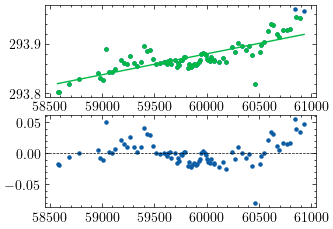

In [6]:
df = pl.read_csv(
    MEERTIME_DIR / f"pulsar_fold_result_{PSR_NAME}.csv", null_values=["None"]
)
# add MJD
df = df.with_columns(pl.Series("MJD", utc_to_mjd(df["UTC Start"]))).sort("MJD")

(DMfit_p, DMfit_res_rms), df_clipped = delDM_estimate_from_DM_measurements(
    df, return_fit=True, fit_order=1
)

gridspec = plt.GridSpec(2, 1)
fig = plt.figure()
ax = fig.add_subplot(gridspec[0, 0])
ax_res = fig.add_subplot(gridspec[1, 0])
ax.sharex(ax_res)

ax.plot(df["MJD"], np.polyval(DMfit_p, df["MJD"]), color="C1")
ax.scatter(df["MJD"], df["DM (pc cm^-3)"], s=5, color="C0")
ax.scatter(df_clipped["MJD"], df_clipped["DM (pc cm^-3)"], s=5, color="C1")
ax.set_xlabel("MJD")

ax_res.scatter(
    df["MJD"], df["DM (pc cm^-3)"] - np.polyval(DMfit_p, df["MJD"]), s=5, color="C0"
)
ax_res.axhline(0, color="k", linestyle="--", linewidth=0.5)

mp.dps=50
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
Updating TOA errors using TN parameters.


Text(0, 0.5, '$\\Delta$DM (pc cm$^{-3}$)')

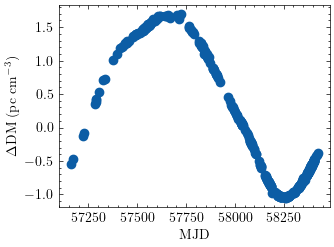

In [7]:
(times, phases, R_phase), (omgc_0_par, omgc_dot_par), (tempo_psr, tempo_res) = (
    PulsarDataLoader(NUME_IMPL).load(PARFILE, TIMFILE)
)
dDM = delDM_bound_from_timing_noise(tempo_psr)

plt.scatter(tempo_psr.toas(), dDM)
plt.xlabel("MJD")
plt.ylabel(r"$\Delta$DM (pc cm$^{-3}$)")

The following cell multi-processes tempo2 running. 

In [8]:
# %%script echo skipping

import multiprocessing as mp
from libstempo_worker import worker

data_dict = {}

partimfiles = [
    (
        psr,
        (
            Path(f"{UTMOST_DATA_PATH}/{psr}/{psr}.par").resolve().as_posix(),
            Path(f"{UTMOST_DATA_PATH}/{psr}/{psr}.tim").resolve().as_posix(),
        ),
    )
    for psr in psr_names_sorted
]


def run_with_timeouts(psr_files, nproc=4, maxtasksperchild=8, task_timeout_sec=5):
    os.environ.setdefault("OMP_NUM_THREADS", "1")
    os.environ.setdefault("MKL_NUM_THREADS", "1")
    os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
    ctx = mp.get_context("spawn")  # critical: avoid fork
    results, failures = {}, {"timeout": [], "error": []}
    psrs, partim = zip(*psr_files)
    with ctx.Pool(processes=nproc, maxtasksperchild=maxtasksperchild) as pool:
        asyncs = [pool.apply_async(worker, pt) for pt in partim]
        for psr, a in zip(psrs, asyncs):
            try:
                dDMmax, Tobs_mjd = a.get(timeout=task_timeout_sec)
                results[psr] = {"dDMmax": dDMmax, "Tobs_mjd": Tobs_mjd}
            except mp.TimeoutError:
                print(f"Timeout: {psr} took longer than {task_timeout_sec} seconds")
                failures["timeout"].append(psr)
            except Exception as e:
                print(f"Exception: {psr} raised {e}")
                failures["error"].append(psr)
    return results, failures


def batched(it, batch_size):
    it = list(it)
    for i in range(0, len(it), batch_size):
        yield it[i : i + batch_size]


result, failures = run_with_timeouts(partimfiles)
if failures:
    print("Failures:")
    for reason, psrs in failures.items():
        if psrs:
            print(f" - {reason}: {', '.join(psrs)}")

# rerun for timeouts
if failures["timeout"]:
    print("Rerunning timeouts...")
    retry_tasks = [
        (
            psr,
            (
                Path(f"{UTMOST_DATA_PATH}/{psr}/{psr}.par").resolve().as_posix(),
                Path(f"{UTMOST_DATA_PATH}/{psr}/{psr}.tim").resolve().as_posix(),
            ),
        )
        for psr in failures["timeout"]
    ]
    retry_result, retry_failures = run_with_timeouts(
        retry_tasks, nproc=2, task_timeout_sec=20
    )
    result.update(retry_result)
    for reason, psrs in retry_failures.items():
        if psrs:
            print(f" - {reason}: {', '.join(psrs)}")
        else:
            print(f"Retry for {reason} succeeded")

print(result, end="\n\n")
# assert len(result) == 300

Working on J0151-0635.par, J0151-0635.timWorking on J0152-1637.par, J0152-1637.tim
Working on J0030+0451.par, J0030+0451.timWorking on J0134-2937.par, J0134-2937.tim


[tempo2Util.C:396] Warning: [PAR2] Have not set a DM epoch. The period epoch will be used instead. /Users/Eric.Dong/Downloads/project-psrtim_population/data/TimingDataRelease1/pulsars/J0030+0451/J0030+0451.par
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
************************************************* 
************************************************* 
Updating TOA errors using TN parameters.
Updating TOA errors using TN parameters.
Updating TOA errors using TN parameters.
Updating TOA errors using TN parameters.
Working on J0206-4028.par, J

In [9]:
import pandas as pd

data_dict = result

for psr in psr_names_sorted:
    df = pl.read_csv(
        MEERTIME_DIR / f"pulsar_fold_result_{psr}.csv", null_values=["None"]
    )
    # meertime data may be empty for some pulsars
    if not df.is_empty():
        # add MJD
        df = df.with_columns(pl.Series("MJD", utc_to_mjd(df["UTC Start"])))
        df = df.sort("MJD")

        data_dict[psr]["dDM_MT"] = np.squeeze(delDM_estimate_from_DM_measurements(df))

print(df := pd.DataFrame(list(data_dict.values()), index=data_dict.keys()))
df["dDM_MT"] = df["dDM_MT"].astype(float)
# print(df := pl.from_dicts(list(data_dict.values())))

Clipped 5 outlier DM measurements
d(DM)/dt trend: 0.11e-3 pc cm^-3 yr^-1
RMS residual: 0.62e-3 pc cm^-3

d(DM)/dt trend: -6.12e-3 pc cm^-3 yr^-1
RMS residual: 4.14e-3 pc cm^-3

Clipped 1 outlier DM measurements
d(DM)/dt trend: 70.87e-3 pc cm^-3 yr^-1
RMS residual: 63.16e-3 pc cm^-3

d(DM)/dt trend: -14.58e-3 pc cm^-3 yr^-1
RMS residual: 42.35e-3 pc cm^-3

d(DM)/dt trend: -476.47e-3 pc cm^-3 yr^-1
RMS residual: 1438.83e-3 pc cm^-3

d(DM)/dt trend: 7.01e-3 pc cm^-3 yr^-1
RMS residual: 6.57e-3 pc cm^-3

d(DM)/dt trend: 6.54e-3 pc cm^-3 yr^-1
RMS residual: 0.77e-3 pc cm^-3

d(DM)/dt trend: -12.53e-3 pc cm^-3 yr^-1
RMS residual: 31.68e-3 pc cm^-3

d(DM)/dt trend: -748.66e-3 pc cm^-3 yr^-1
RMS residual: nane-3 pc cm^-3

d(DM)/dt trend: -0.64e-3 pc cm^-3 yr^-1
RMS residual: 0.28e-3 pc cm^-3

Clipped 4 outlier DM measurements
d(DM)/dt trend: 4.99e-3 pc cm^-3 yr^-1
RMS residual: 69.27e-3 pc cm^-3

d(DM)/dt trend: 1.58e-3 pc cm^-3 yr^-1
RMS residual: 42.94e-3 pc cm^-3

Clipped 4 outlier DM measu

In [10]:
# df.sort_values("dDMmax", inplace=True)
df.sort_values("dDM_MT", inplace=True)
df[-35:-20]

,dDMmax,Tobs_mjd,dDM_MT
J1133-6250,5.450737,"(57989.14625377537, 58424.95848007702)",0.269429
J1910+0358,3.072968,"(57556.712413417736, 58409.31252947684)",0.454259
J1837-0653,3.514138,"(57557.5904807103, 58354.445565423055)",0.498872
J0206-4028,0.420042,"(57297.67543099705, 58491.37345517113)",1.438831
J1622-4950,6081.952612,"(57979.36866739866, 58410.1966877614)",20.308982
J2038-3816,1.605624,"(57549.82977980943, 58406.3791371453)",30.235152
J0418-4154,1.526430,"(57305.566326647706, 58508.418001621096)",NaN
J1032-5911,1.435979,"(57558.3061718217, 58453.82976548121)",NaN
J1231-6303,8.444255,"(57221.216873095436, 58425.99969287721)",NaN
J1312-5402,0.919618,"(57290.15140466024, 58422.026563076615)",NaN


In [11]:
psr105 = [
    "J0401-7608",
    "J0452-1759",
    "J0627+0706",
    "J0659+1414",
    "J0729-1836",
    "J0738-4042",
    "J0742-2822",
    "J0758-1528",
    "J0809-4753",
    "J0837-4135",
    "J0907-5157",
    "J0908-4913",
    "J0922+0638",
    "J0942-5657",
    "J1001-5507",
    "J1043-6116",
    "J1048-5832",
    "J1056-6258",
    "J1057-5226",
    "J1105-6107",
    "J1110-5637",
    "J1112-6613",
    "J1114-6100",
    "J1116-4122",
    "J1121-5444",
    "J1136+1551",
    "J1136-5525",
    "J1141-6545",
    "J1157-6224",
    "J1202-5820",
    "J1210-5559",
    "J1224-6407",
    "J1239-6832",
    "J1243-6423",
    "J1253-5820",
    "J1305-6455",
    "J1306-6617",
    "J1319-6056",
    "J1320-5359",
    "J1326-5859",
    "J1326-6408",
    "J1326-6700",
    "J1327-6222",
    "J1328-4357",
    "J1356-5521",
    "J1359-6038",
    "J1401-6357",
    "J1413-6307",
    "J1430-6623",
    "J1452-6036",
    "J1453-6413",
    "J1507-4352",
    "J1512-5759",
    "J1522-5829",
    "J1527-5552",
    "J1534-5405",
    "J1539-5626",
    "J1557-4258",
    "J1600-5044",
    "J1604-4909",
    "J1623-4256",
    "J1644-4559",
    "J1651-4246",
    "J1651-5255",
    "J1705-3423",
    "J1709-1640",
    "J1711-5350",
    "J1717-3425",
    "J1717-4054",
    "J1722-3712",
    "J1739-2903",
    "J1741-3927",
    "J1745-3040",
    "J1752-2806",
    "J1759-2205",
    "J1803-2137",
    "J1820-0427",
    "J1823-3106",
    "J1824-1945",
    "J1827-0750",
    "J1829-1751",
    "J1832-0827",
    "J1833-0338",
    "J1833-0827",
    "J1836-1008",
    "J1841+0912",
    "J1843-0000",
    "J1848-0123",
    "J1849-0636",
    "J1901+0331",
    "J1903+0135",
    "J1903-0632",
    "J1909+0007",
    "J1909+1102",
    "J1913-0440",
    "J1916+0951",
    "J1916+1312",
    "J1917+1353",
    "J1932+1059",
    "J1935+1616",
    "J2116+1414",
    "J0437-4715",  # MSP
    "J2145-0750",  # MSP
    "J2241-5236",  # MSP
    "J1622-4950",  # magnetar
]

In [12]:
def set_equal_axes(ax, plot_diag=True, aspect="equal"):
    """Set equal axes for a scatter plot."""
    ax.set_aspect(aspect, adjustable="box")
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    lim = (
        (np.min([xmin, ymin]), np.max([xmax, ymax]))
        if aspect == "equal"
        else (ymin, ymax)
    )
    if plot_diag:
        ## dashed line for y=x
        ax.plot(lim, lim, color="gray", linestyle="--")

In [13]:
%%script echo skipping

plt.figure(figsize=(9, 9), dpi=300)
plt.scatter(
    np.log10(df["dDMmax"]),
    np.log10(df["dDM_MT"]),
    s=5,
    color="tab:green",
    marker="o",
    alpha=0.2,
)
plt.scatter(
    np.log10(df["dDMmax"].loc[psr105]),
    np.log10(df["dDM_MT"].loc[psr105]),
    s=5,
    color="tab:purple",
    marker="o",
    alpha=0.5,
)
set_equal_axes(plt.gca(), aspect="auto")
plt.xlabel(r"$\log_{10}|\Delta \text{DM}|_{\rm max}$ (pc cm$^{-3}$)")
plt.ylabel(r"$\log_{10}|\Delta \text{DM}|_{\rm MT}$ (pc cm$^{-3}$)")

# label orange points that are above y=x line
temp_df = df.loc[psr105]
is_above = temp_df["dDM_MT"] > temp_df["dDMmax"]
is_half_below = temp_df["dDM_MT"] > 0.5 * temp_df["dDMmax"]
for psr, row in temp_df[is_above & is_half_below].iterrows():
    plt.text(
        np.log10(row["dDMmax"]),
        np.log10(row["dDM_MT"]),
        psr,
        fontsize=7,
        alpha=1,
    )
# label MSPs
for psr in ["J0437-4715", "J2145-0750", "J2241-5236"]:
    row = df.loc[psr]
    plt.text(
        np.log10(row["dDMmax"]),
        np.log10(row["dDM_MT"]),
        psr,
        fontsize=7,
        alpha=1,
    )


skipping


Check those orange objects that above the $y=x$ line

In [14]:
%%script echo skipping

for psr in temp_df[is_above].index:
    _df = pl.read_csv(
        MEERTIME_DIR / f"pulsar_fold_result_{psr}.csv", null_values=["None"]
    )
    # add MJD
    _df = _df.with_columns(pl.Series("MJD", utc_to_mjd(_df["UTC Start"]))).sort("MJD")

    (DMfit_p, DMfit_res_rms), _ = delDM_estimate_from_DM_measurements(
        _df, return_fit=True
    )
    outlier_mask = sigma_clip(
        _df["DM (pc cm^-3)"] - np.polyval(DMfit_p, _df["MJD"]),
        sigma=5,
        maxiters=None,
    ).mask
    _df = _df.filter(~outlier_mask)
    plt.figure()
    plt.plot(_df["MJD"], np.polyval(DMfit_p, _df["MJD"]), color="C1")
    plt.scatter(_df["MJD"], _df["DM (pc cm^-3)"], s=5)
    plt.xlabel("MJD")


skipping


Compare $\sigma_{\rm TN}$ with $|\delta \text{DM}|_{\rm MT}$

In [15]:
from timkf.misc.util_funcs import is_magnetar, is_recycled_millisecond, B_surf

RESULTS_DIR = "../results-utmost/outdirDR1nlive2e3/s917-nw20-r8-tau2_9-Qc30_14-Qs30_14-lag2-EFAC0_4-EQUAD40_2-omgc_0"
STRONG_LNBF_THRESH = 5

csv_name = (Path(RESULTS_DIR) / "model_comparison.csv").resolve().as_posix()
df_PE = pl.read_csv(csv_name)

for p in ["tau", "Qc", "Qs", "TN", "ratio", "taueff"]:
    # convert the logq columns from string to list of floats
    df_PE = df_PE.with_columns(
        pl.col(f"logq_{p}")
        .str.json_decode()
        .list.eval(pl.element().cast(pl.Float64))
        .alias(f"logq_{p}")
    )
    # get the median (1st element of the list)
    df_PE = df_PE.with_columns(pl.col(f"logq_{p}").list.get(0).alias(f"log{p}_med"))
    # get the 68% error
    df_PE = df_PE.with_columns(
        (
            pl.col(f"logq_{p}").list.get(1).cast(pl.Float64)
            - pl.col(f"logq_{p}").list.get(0).cast(pl.Float64)
        ).alias(f"log{p}_68err_low"),
    ).with_columns(
        (
            pl.col(f"logq_{p}").list.get(2).cast(pl.Float64)
            - pl.col(f"logq_{p}").list.get(0).cast(pl.Float64)
        ).alias(f"log{p}_68err_upp"),
    )
    df_PE = df_PE.with_columns(
        pl.struct(
            [
                f"log{p}_68err_low",
                f"log{p}_68err_upp",
            ]
        ).alias(f"log{p}_68err")
    ).drop(f"log{p}_68err_low", f"log{p}_68err_upp")

# recast the column names
df_PE = df_PE.with_columns(
    pl.col("logBF_2Cmpnt_vs_WTNnullHypothesis").alias("lnBF"),
).drop("logBF_2Cmpnt_vs_WTNnullHypothesis")
# drop other unnecessary columns
df_PE = df_PE.drop(
    "log_evidence_2Cmpnt",
    "log_evidence_WTNnullHypothesis",
    "logBF_per_TOA_2Cmpnt_vs_WTNnullHypothesis",
    "log_ratio-dist",
)
print(f"{df_PE.columns=}")

# Filter the dataframe with strong Bayes factor, typically lnBF > 5
df_lnBF5 = df_PE.filter(pl.col("lnBF") > STRONG_LNBF_THRESH)

# add the columns for the recycled millisecond pulsar, magnetar, and canonical pulsar
df_PE = df_PE.with_columns(
    is_recycled_millisecond(
        pl.col("omgc_0") / (2 * np.pi), pl.col("omgc_dot") / (2 * np.pi)
    ).alias("msp"),
    is_magnetar(B_surf(pl.col("omgc_0"), pl.col("omgc_dot"))).alias("magnetar"),
)
## whatever is not msp or magnetar is canonical
df_PE = df_PE.with_columns(
    (~pl.col("msp") & ~pl.col("magnetar")).alias("canonical"),
)

# Filter the dataframe for different types of pulsars
df_msp = df_PE.filter(pl.col("msp")).drop("msp", "magnetar", "canonical")
df_magnetar = df_PE.filter(pl.col("magnetar")).drop("msp", "magnetar", "canonical")
df_canonical = df_PE.filter(pl.col("canonical")).drop("msp", "magnetar", "canonical")

df_PE.columns=['PSRJ', 'omgc_dot', 'omgc_0', 'logq_taueff', 'logq_tau', 'logq_ratio', 'logq_TN', 'logq_Qs', 'logq_Qc', 'log_tau-dist', 'log_Qs-dist', 'log_Qc-dist', 'Tobs', 'TSTART', 'TFINISH', 'NTOAs', 'logtau_med', 'logtau_68err', 'logQc_med', 'logQc_68err', 'logQs_med', 'logQs_68err', 'logTN_med', 'logTN_68err', 'logratio_med', 'logratio_68err', 'logtaueff_med', 'logtaueff_68err', 'lnBF']


In [16]:
def delDM_bound_from_sigma_TN(residuals, freq_band_GHz=835e-3):
    residuals = residuals * SEC_TO_MSEC  # in ms

    DM_variations = residuals / (K_DM * freq_band_GHz**-2)

    return DM_variations

Number of pulsars with finite |dDM|_max: 295
Number of objects with finite dDM_MT: 271


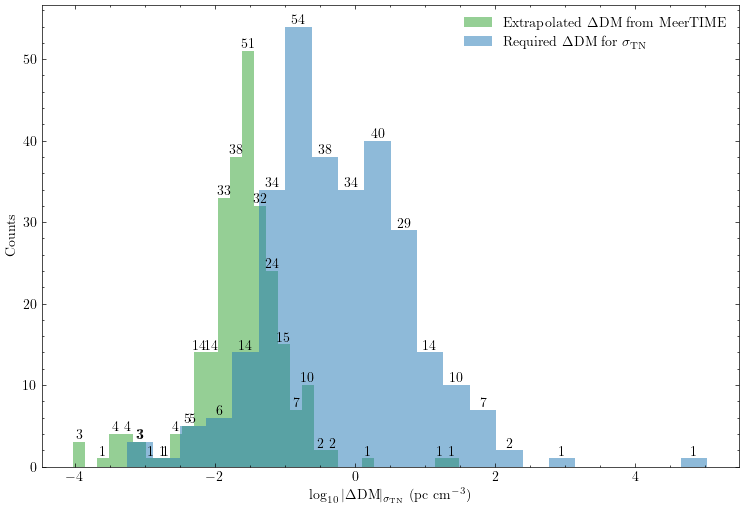

In [17]:
ax = plt.figure(figsize=(9, 6)).gca()
# plot_medians_hist(
#     np.log10(df["dDMmax"]),
#     ax=ax,
#     xlabel=r"$\log_{10}|\Delta \text{DM}|_{\rm max}$ (pc cm$^{-3}$)",
#     label=r"Required $\Delta$DM for the maximum timing noise",
#     show_title=False,
#     color="tab:purple",
# )
plot_medians_hist(
    np.log10(df["dDM_MT"][df["dDM_MT"] > 0]),
    ax=ax,
    xlabel=r"$\log_{10}|\Delta \text{DM}|_{\rm MT}$ (pc cm$^{-3}$)",
    label=r"Extrapolated $\Delta$DM from MeerTIME",
    show_title=False,
    color="tab:green",
)
dDM_TN = delDM_bound_from_sigma_TN(10 ** (0.5 * df_PE["logTN_med"]))
dDM_TN_q16 = delDM_bound_from_sigma_TN(
    10 ** (0.5 * (df_PE["logq_TN"].list.get(1).cast(pl.Float64)))
)
dDM_TN_q84 = delDM_bound_from_sigma_TN(
    10 ** (0.5 * (df_PE["logq_TN"].list.get(2).cast(pl.Float64)))
)
df_PE = df_PE.with_columns(pl.Series(dDM_TN).alias("dDM_TN"))
df_PE = df_PE.with_columns(pl.Series(dDM_TN_q16).alias("dDM_TN_q16"))
df_PE = df_PE.with_columns(pl.Series(dDM_TN_q84).alias("dDM_TN_q84"))
plot_medians_hist(
    np.log10(dDM_TN),
    ax=ax,
    xlabel=r"$\log_{10}|\Delta \text{DM}|_{\sigma_{\rm TN}}$ (pc cm$^{-3}$)",
    label=r"Required $\Delta$DM for $\sigma_{\rm TN}$",
    show_title=False,
    color="tab:blue",
)
plt.legend()
print(f"Number of pulsars with finite |dDM|_max: {df['dDMmax'].notna().sum()}")
print(f"Number of objects with finite dDM_MT: {df['dDM_MT'].notna().sum()}")

Number of common pulsars: 293
Number of common pulsars with dDM_MT: 265
Number of common pulsars with dDM_MT and lnBF > 5: 101; missing: {'J1717-4054', 'J1623-4256', 'J1711-5350', 'J1651-5255'}


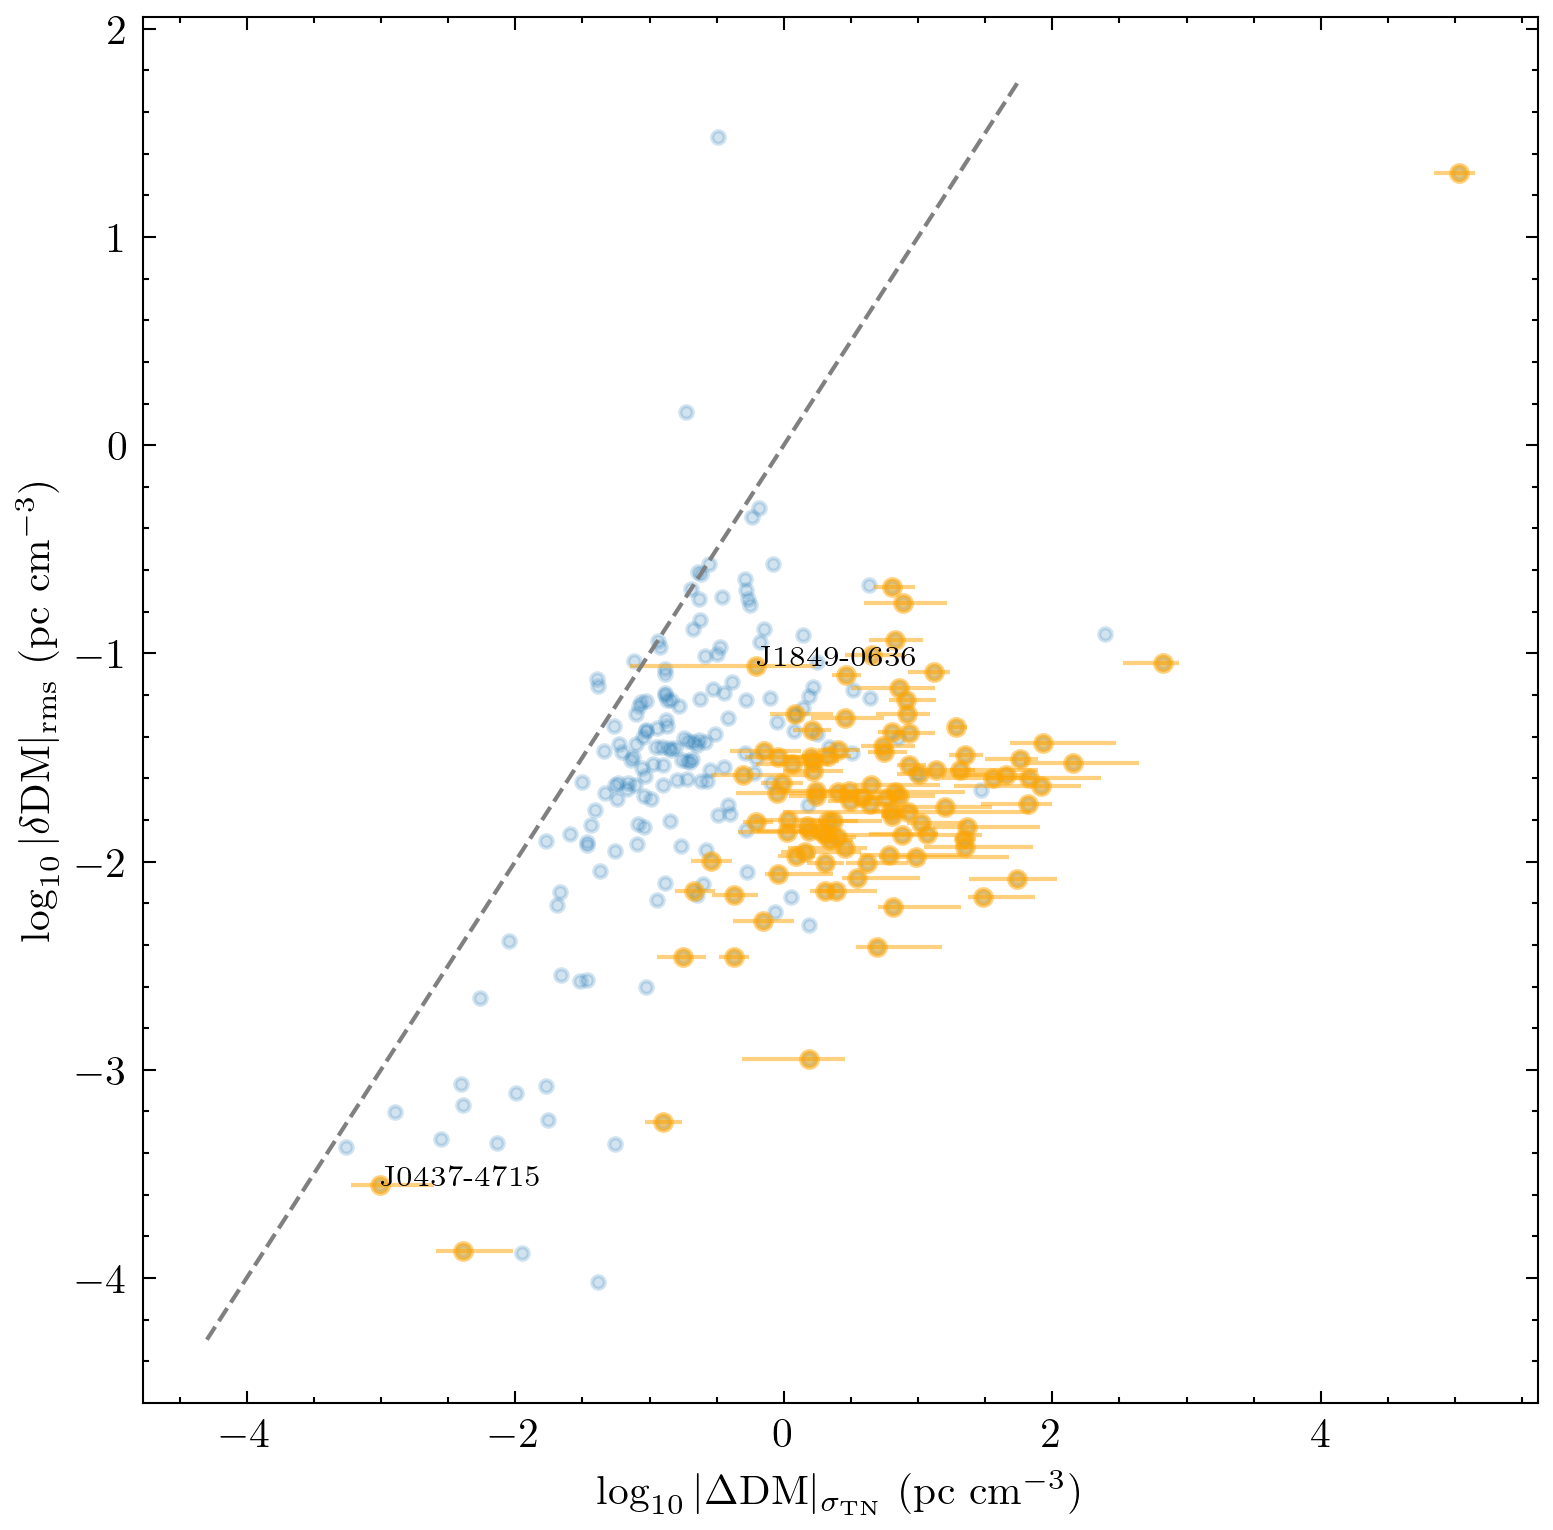

In [18]:
df_PE_pd = df_PE.to_pandas()
df_PE_pd.index = df_PE_pd["PSRJ"]

plt.figure(figsize=(6, 6), dpi=300)
common_index = df.index.intersection(df_PE_pd.index)
print(f"Number of common pulsars: {len(common_index)}")
print(
    f"Number of common pulsars with dDM_MT: {len(df[df['dDM_MT'].notna()].index.intersection(df_PE_pd.index))}"
)
print(
    f"Number of common pulsars with dDM_MT and lnBF > {STRONG_LNBF_THRESH}: {len(df[df['dDM_MT'].notna()].index.intersection(psr105))}; missing: {set(psr105) - set(df[df['dDM_MT'].notna()].index.intersection(psr105))}"
)
plt.scatter(
    np.log10(df_PE_pd["dDM_TN"].loc[common_index]),
    np.log10(df["dDM_MT"].loc[common_index]),
    s=9,
    color="tab:blue",
    marker="o",
    alpha=0.2,
)
plt.gca().errorbar(
    np.log10(df_PE_pd["dDM_TN"].loc[common_index].loc[psr105]),
    np.log10(df["dDM_MT"].loc[common_index].loc[psr105]),
    xerr=(
        (
            np.log10(df_PE_pd["dDM_TN"].loc[common_index].loc[psr105])
            - np.log10(df_PE_pd["dDM_TN_q16"].loc[common_index].loc[psr105])
        ),
        (
            np.log10(df_PE_pd["dDM_TN_q84"].loc[common_index].loc[psr105])
            - np.log10(df_PE_pd["dDM_TN"].loc[common_index].loc[psr105])
        ),
    ),
    fmt="o",
    color="orange",
    ms=4,
    alpha=0.5,
)
set_equal_axes(plt.gca(), aspect="auto")
plt.xlabel(r"$\log_{10}|\Delta \text{DM}|_{\sigma_{\rm TN}}$ (pc cm$^{-3}$)")
plt.ylabel(r"$\log_{10}|\delta \text{DM}|_{\rm rms}$ (pc cm$^{-3}$)")

# label orange points that are above y=x line
temp_df = df.loc[psr105]
temp_df = temp_df.join(df_PE_pd[["dDM_TN", "dDM_TN_q16", "dDM_TN_q84"]], how="inner")
temp_df["dDM_ratio"] = temp_df["dDM_MT"] / temp_df["dDM_TN"]
temp_df["dDM_ratio_q16"] = temp_df["dDM_MT"] / temp_df["dDM_TN_q16"]
temp_df["dDM_ratio_q84"] = temp_df["dDM_MT"] / temp_df["dDM_TN_q84"]
geq_10pc = temp_df["dDM_ratio_q16"] > 0.1
for psr, row in temp_df[geq_10pc].iterrows():
    plt.text(
        np.log10(df_PE_pd["dDM_TN"].loc[psr]),
        np.log10(row["dDM_MT"]),
        psr,
        fontsize=7,
        alpha=1,
    )
# label MSPs
# for psr in df_msp.filter(pl.col("lnBF") > STRONG_LNBF_THRESH)["PSRJ"].to_list():
#     row = df.loc[psr]
#     plt.text(
#         np.log10(df_PE_pd["dDM_TN"].loc[psr]),
#         np.log10(row["dDM_MT"]),
#         psr,
#         fontsize=7,
#         alpha=1,
#     )
plt.savefig("../docs/paperplots/dDM_MT_vs_dDM_TN.png", bbox_inches="tight", dpi=300)
plt.savefig("../docs/paperplots/dDM_MT_vs_dDM_TN.pdf", bbox_inches="tight", dpi=300)

Pulsars with dDM_MT / dDM_TN > 0.1: 
              dDMmax                                Tobs_mjd    dDM_MT  \
J1849-0636  0.806576  (57277.43648920562, 58427.25027187334)  0.087340   
J0437-4715  0.009197   (57939.98743074236, 58442.6119894906)  0.000278   

              dDM_TN  dDM_TN_q16  dDM_TN_q84  dDM_ratio  dDM_ratio_q16  \
J1849-0636  0.626096    0.071032    1.711735   0.139499       1.229581   
J0437-4715  0.000982    0.000602    0.002476   0.283274       0.462320   

            dDM_ratio_q84  
J1849-0636       0.051024  
J0437-4715       0.112391  
            dDMmax     dDM_MT         dDM_TN    dDM_TN_q16     dDM_TN_q84  \
count   101.000000  99.000000     103.000000    103.000000     103.000000   
mean     61.839997   0.232981    1052.809852    684.499234    1399.989829   
std     605.026391   2.038543   10503.920788   6851.157280   13850.836717   
min       0.007292   0.000134       0.004074      0.002566       0.009558   
25%       0.370204   0.012188       1.630997    

,dDMmax,Tobs_mjd,dDM_MT,dDM_TN,dDM_TN_q16,dDM_TN_q84,dDM_ratio,dDM_ratio_q16,dDM_ratio_q84
J0437-4715,0.009197,"(57939.98743074236, 58442.6119894906)",0.000278,0.000982,0.000602,0.002476,0.283274,0.462320,0.112391
J1849-0636,0.806576,"(57277.43648920562, 58427.25027187334)",0.087340,0.626096,0.071032,1.711735,0.139499,1.229581,0.051024
J1745-3040,0.140666,"(57172.70945461265, 58422.21511672202)",0.026052,0.496983,0.288303,1.557800,0.052420,0.090362,0.016723
J2116+1414,0.413122,"(57294.538129630375, 58427.348799511565)",0.034141,0.713629,0.397230,1.338328,0.047842,0.085949,0.025511
J1527-5552,0.755222,"(57284.29024689862, 58426.1054282879)",0.051255,1.213221,0.789907,2.313762,0.042247,0.064887,0.022152
...,...,...,...,...,...,...,...,...,...
J1048-5832,37.507308,"(57191.435434533734, 58415.94856421744)",0.090062,662.775938,336.293932,883.449625,0.000136,0.000268,0.000102
J1623-4256,0.879598,"(57173.59715597108, 58411.191492368016)",NaN,2.361982,1.367043,4.508503,NaN,NaN,NaN
J1651-5255,1.290339,"(57307.29869006847, 58426.16601847452)",NaN,5.739749,2.955515,10.023951,NaN,NaN,NaN
J1711-5350,0.689975,"(57307.36275563141, 58413.21878316013)",NaN,4.071514,1.911052,7.561563,NaN,NaN,NaN


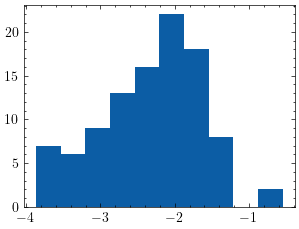

In [19]:
plt.hist(np.log10(temp_df["dDM_ratio"]))
print(f"Pulsars with dDM_MT / dDM_TN > 0.1: \n{temp_df[geq_10pc]}")
print(temp_df[~geq_10pc].describe())
temp_df.sort_values("dDM_ratio", ascending=False)

04/11/2025 14:32:40 Input data contains invalid values (NaNs or infs), which were automatically clipped.
04/11/2025 14:32:40 Input data contains invalid values (NaNs or infs), which were automatically clipped.


Plotting DM time series for J1745-3040
Clipped 1 outlier DM measurements
d(DM)/dt trend: 9.57e-3 pc cm^-3 yr^-1
RMS residual: 26.05e-3 pc cm^-3

Plotting DM time series for J1709-1640
Clipped 7 outlier DM measurements
d(DM)/dt trend: -2.87e-3 pc cm^-3 yr^-1
RMS residual: 18.86e-3 pc cm^-3



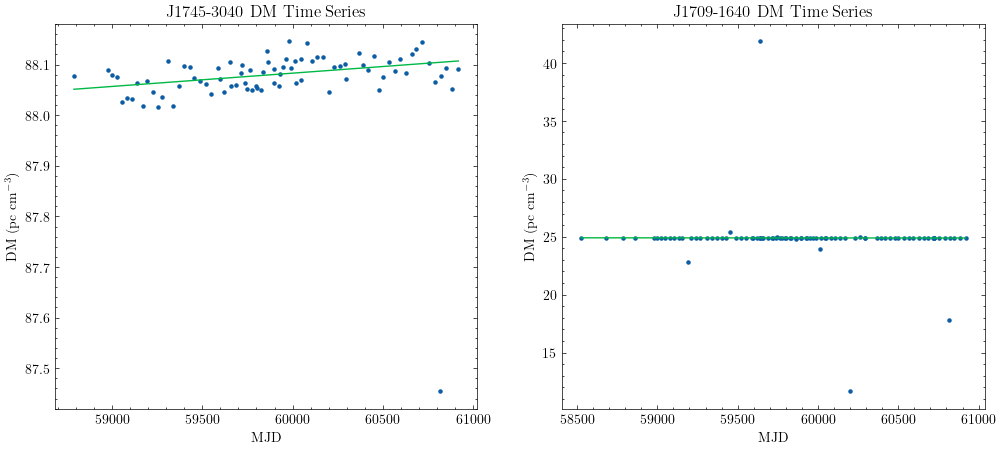

In [ ]:
# for psr in temp_df[geq_10pc].index:
_selected_psrs = ["J1745-3040", "J1709-1640", "1849-0636"]
gridspec = plt.GridSpec(1, len(_selected_psrs))
fig = plt.figure(figsize=(6 * len(_selected_psrs), 5))
for i, psr in enumerate(_selected_psrs):
    print(f"Plotting DM time series for {psr}")
    _df = pl.read_csv(
        MEERTIME_DIR / f"pulsar_fold_result_{psr}.csv", null_values=["None"]
    )
    # add MJD
    _df = _df.with_columns(pl.Series("MJD", utc_to_mjd(_df["UTC Start"]))).sort("MJD")

    (DMfit_p, DMfit_res_rms), _ = delDM_estimate_from_DM_measurements(
        _df, return_fit=True, clip_sigma=3
    )
    outlier_mask = sigma_clip(_df["DM (pc cm^-3)"], sigma=3, maxiters=None).mask
    _df_clipped = _df.filter(~outlier_mask)
    ax = fig.add_subplot(gridspec[0, i])
    # plot the fitted line (after clipping)
    ax.plot(_df_clipped["MJD"], np.polyval(DMfit_p, _df_clipped["MJD"]), color="C1")
    ax.scatter(_df["MJD"], _df["DM (pc cm^-3)"], s=5)  # all points
    ax.set_xlabel("MJD")
    ax.set_ylabel("DM (pc cm$^{-3}$)")
    ax.set_title(f"{psr} DM Time Series")
